Pipeline:

\- read data

\- separate training and validation dataset 

1. Baseline model 
    - dummy

2. Logistic regression 
    - RFE Feature selection 
    - Hyperparameter tuning 
    - Interpretation 
        - by weights 
        - by SHAP 
3. Other ML classifiers 

--- still considering using SMOTE 

In [1]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import string 
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from regressors import stats
from sklearn.feature_selection import chi2

In [2]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt
import time

# pip install ipython-autotime
import autotime
from sklearn.feature_selection import RFECV

from sklearn.metrics import make_scorer, precision_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve

from itertools import compress
import matplotlib
import matplotlib.pyplot as plt

#import shap
#shap.initjs()

In [3]:
def show_scores(model, X_train, y_train, X_test, y_test, show=True):
    """
    Calculate the scores 
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    score_result = {"accuracy":[], "recall":[], "precision":[], "roc_auc_score":[], "f1_score":[]}
    score_result["accuracy"].append(round(accuracy_score(y_train, y_pred_train), 2))
    score_result["accuracy"].append(round(accuracy_score(y_test, y_pred_test), 2))
    score_result["recall"].append(round(recall_score(y_train, y_pred_train), 2))
    score_result["recall"].append(round(recall_score(y_test, y_pred_test), 2))
    score_result["precision"].append(round(precision_score(y_train, y_pred_train), 2))
    score_result["precision"].append(round(precision_score(y_test, y_pred_test), 2))
    score_result["roc_auc_score"].append(round(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]), 2))
    score_result["roc_auc_score"].append(round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 2))
    score_result["f1_score"].append(round(f1_score(y_train, y_pred_train), 2))
    score_result["f1_score"].append(round(f1_score(y_test, y_pred_test), 2))
    if show:
        score_result = pd.DataFrame(score_result, index=["train", "valid"])
        return score_result
    else:
        return 

In [4]:
def show_weights(feat_names, weights, num):
    #feat_names #= X_train_sel_cols
    #weights #= lr.coef_.flatten()

    # Sort the coefficients in descending order 
    inds = np.argsort(weights)

    # pick the first 20 as most informative features for negative reviews  
    negative_words = [feat_names[index] for index in inds[:num]]

    # pick the last 20 features as most informative features for positive reviews  
    positive_words = [feat_names[index] for index in inds[-num:][::-1]]

    neg_words_weights = [(weights[index]) for index in inds[:num]]
    pos_words_weights = [(weights[index]) for index in inds[-num:][::-1]]

    df = pd.DataFrame({'Neg feats':negative_words, 'Neg weights':neg_words_weights, 
                       'Pos feats':positive_words, 'Pos weights':pos_words_weights})
    return df

In [5]:
def show_probs(employee_code, y_obs, y_pred, probs, dataset = "train"):
    '''
    Show probabilities 
    '''
    if dataset == "train":
        df1 = pd.DataFrame({"employee_code": employee_code, "y_obs_train": y_obs, "y_pred_train":y_pred}).reset_index(drop=True)
        df2 = pd.DataFrame(columns=["non-high performer", "high performer"],  data=probs)
        df_prob = pd.concat([df1, df2], axis =1)
        df_prob["False_positive"] = df_prob.apply(lambda row: 1 if row.y_obs_train == 0 and row.y_pred_train == 1 else 0, axis=1)
        df_prob["False_negative"] = df_prob.apply(lambda row: 1 if row.y_obs_train == 1 and row.y_pred_train == 0 else 0, axis=1)
    elif dataset == "valid":
        df1 = pd.DataFrame({"employee_code": employee_code, "y_obs_valid": y_obs, "y_pred_valid":y_pred}).reset_index(drop=True)
        df2 = pd.DataFrame(columns=["non-high performer", "high performer"],  data=probs)
        df_prob = pd.concat([df1, df2], axis =1)
        df_prob["False_positive"] = df_prob.apply(lambda row: 1 if row.y_obs_valid == 0 and row.y_pred_valid ==1 else 0, axis=1)
        df_prob["False_negative"] = df_prob.apply(lambda row: 1 if row.y_obs_valid == 1 and row.y_pred_valid ==0 else 0, axis=1)
    return df_prob

In [6]:
# Train data 
#df = pd.read_csv("../data/0604_training_dataset.csv")
df = pd.read_csv("C:/Users/NIW/Glentel Inc/HR Analytics - Capstone Data/ubc_mds_team_share/06_clean_data/0605_training_dataset.csv")
df.head(5)

,employee_code,rehired_,referral_flag,job_hopper,competitor_experience,Freedom_competitor_exp,Koodo_competitor_exp,Shaw_competitor_exp,Telus_competitor_exp,Bell_competitor_exp,...,hp_class,_industry_exp,Clothing & Footwear_industry_exp,Consumer electronics_industry_exp,Food Service_industry_exp,Food-Convenience-Pharmacy_industry_exp,Other_industry_exp,Sport_Travel_Enterntain_Hotel_industry_exp,Telecommunications_industry_exp,unknown_industry_exp
0,MZE,No,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,MRU,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,LAP,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,MYD,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,JJB,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [7]:
df.columns

Index(['employee_code', 'rehired_', 'referral_flag', 'job_hopper',
       'competitor_experience', 'Freedom_competitor_exp',
       'Koodo_competitor_exp', 'Shaw_competitor_exp', 'Telus_competitor_exp',
       'Bell_competitor_exp', 'Rogers_competitor_exp',
       'The Mobile Shop_competitor_exp', 'Best Buy_competitor_exp',
       'Videotron_competitor_exp', 'Wow[!]* Mobile_competitor_exp',
       'The Source_competitor_exp', 'Walmart_competitor_exp',
       'Virgin Mobile_competitor_exp', 'Osl_competitor_exp',
       'accounting_concentration', 'arts_concentration',
       'business_concentration', 'computer_systems_concentration',
       'engineering_concentration', 'finance_concentration',
       'general_concentration', 'human_resource_concentration',
       'interactive_arts_and_technology_concentration',
       'marketing_concentration', 'not_specified_concentration',
       'other_concentration', 'administrative', 'assistant manager',
       'blue collar', 'cashier', 'cook', 'cu

In [8]:
df.groupby(['fitness/sports']).agg({"employee_code":"count","hp_class":"mean"})

,employee_code,hp_class
fitness/sports,,
0.0,271,0.254613
1.0,17,0.058824


In [9]:
# Split data 
X_train = df.drop(columns=["hp_class"])
y_train = df["hp_class"]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                         train_size=0.8, random_state=1234)

In [10]:
numeric_features =['referral_flag', 
               "job_hopper",               #avg_work 
               'competitor_experience',
               #'Freedom_competitor_exp', 'Koodo_competitor_exp', 'Shaw_competitor_exp',
               #'Telus_competitor_exp', 'Bell_competitor_exp', 'Rogers_competitor_exp',
               #'The Mobile Shop_competitor_exp', 'Best Buy_competitor_exp',
               #'Videotron_competitor_exp', 'Wow[!]* Mobile_competitor_exp',
               #'The Source_competitor_exp', 'Walmart_competitor_exp',
               #'Virgin Mobile_competitor_exp', 'Osl_competitor_exp',    #competitor_experience
               'accounting_concentration',
       'arts_concentration', 'business_concentration',
       'computer_systems_concentration', 'engineering_concentration',
       'finance_concentration', 'general_concentration',
       'human_resource_concentration',
       'interactive_arts_and_technology_concentration',
       'marketing_concentration', #'not_specified_concentration',
       'other_concentration',#education concentration 
               'administrative', 'assistant manager', 'blue collar', 'cashier', 'cook',
               'customer service representative', 'driver', 'education',
               'financial services', 'fitness/sports', 'manager', 'no work', 'other',
               'sales associate', 'technicians', 'telemarketers', # work_title 
               'sales_exp', 'customer_serv_exp','leader_ship_exp', #sales_cus_exp
               #'efficient service', 'mobile expert', 'high school',
                #'information system', 'cash register', # word count
               'raw_date_chall_readability', # communication level 
               'food_service_industry_exp',
               'apparel_industry_exp', 'supercenter_convenience_industry_exp',
               'automotive_sales_industry_exp', 'blue_collar_industry_exp',
               'consumer_electronics', #industry_exp
               'no_lang_spoken', 'trilingual_flag', 'goal_record',
               'sales_customer_base_exp', 'volunteer_exp', 'problem_solver',
               'sports_mention', 'communication_skills', 'team_player',
               'leadership_mention']# others features in consolidate dataset 
                   # new_industry_cat updated
                #'Clothing & Footwear_industry_exp',
       #'Consumer electronics_industry_exp', 'Food Service_industry_exp',
       #'Food-Convenience-Pharmacy_industry_exp', 'Other_industry_exp',
       #'Sport_Travel_Enterntain_Hotel_industry_exp',
       #'Telecommunications_industry_exp', 'unknown_industry_exp'] 
                
categorical_features = ['rehired_', 'highest_degree', 'country_highest_degree', 'background_highest_degree'] #'background_highest_degree', 'country_highest_degree']

In [11]:
# Preprocess 
numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())
                                    ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='constant', 
                                                                    fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

## Dummy baseline 

Fitting baseline model: 


,model,accuracy,recall,precision,roc_auc_score,f1_score
train,dummy,0.64,0.29,0.29,0.55,0.29
valid,dummy,0.69,0.33,0.29,0.43,0.31


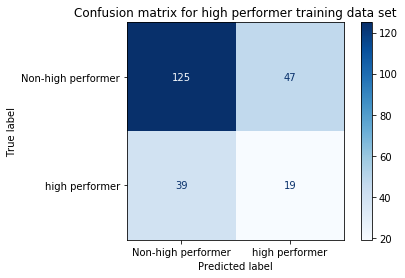

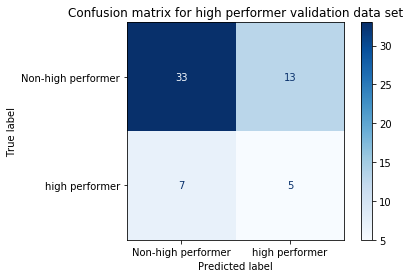

In [12]:
# Baseline model
from sklearn.dummy import DummyClassifier
print('Fitting baseline model: ')
dummy = DummyClassifier()

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', dummy)])

clf.fit(X_train, y_train)
disp = plot_confusion_matrix(clf, X_train, y_train,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer validation data set')
m1 = show_scores(clf, X_train, y_train, X_valid, y_valid)
m1.insert(0,"model","dummy")
m1

## Logistic regression

In [13]:
clf_featr_sele = LogisticRegression(solver='liblinear', penalty="l1") 
rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'f1'
             )

weights = np.linspace(0.1, 0.5, 9)
lg_param_grid = {"C": [0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 10],
                'class_weight': [{0: x, 1: 1.0-x} for x in weights],
                 'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                 'penalty':["l1", "l2"]
                }
CV_rfc = GridSearchCV(clf_featr_sele, 
                      lg_param_grid,
                     cv= 5, scoring = 'f1')

In [14]:
# Baseline model 
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_sele',rfecv),
                         ('clf_cv',CV_rfc)])

In [15]:
clf.fit(X_train, y_train);


Text(0.5, 1.0, 'Confusion matrix for high performer training data set')

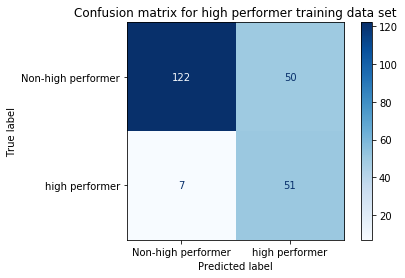

In [16]:
disp = plot_confusion_matrix(clf, X_train, y_train,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer training data set')

Text(0.5, 1.0, 'Confusion matrix for high performer validation data set')

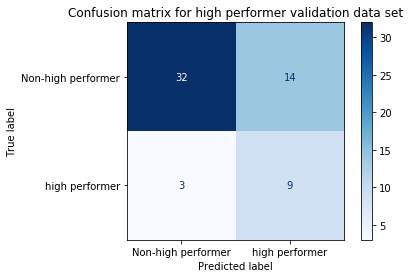

In [17]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer validation data set')


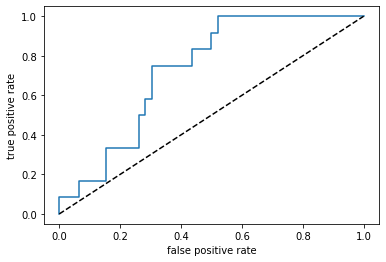

In [18]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate

fpr, tpr, thresholds = roc_curve(y_valid, clf.predict_proba(X_valid)[:,1])

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');

In [19]:
print("Best param is: ", CV_rfc.best_params_)


Best param is:  {'C': 2.0, 'class_weight': {0: 0.2, 1: 0.8}, 'l1_ratio': 0, 'penalty': 'l2'}


In [20]:
m2 =show_scores(clf, X_train, y_train, X_valid, y_valid)
m2.insert(0,"model","logistic_regression-m2")
m2

,model,accuracy,recall,precision,roc_auc_score,f1_score
train,logistic_regression-m2,0.75,0.88,0.50,0.84,0.64
valid,logistic_regression-m2,0.71,0.75,0.39,0.73,0.51


In [21]:
# Take out the training dataset after preprocessing 
X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train),
                           index=X_train.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))
X_valid_trans = pd.DataFrame(preprocessor.fit(X_train).transform(X_valid),
                           index=X_valid.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))

In [22]:
scores = cross_validate(lr, X_train_sel, y_train, cv=5,
                        scoring=('accuracy','f1','recall','precision','roc_auc'),
                        return_train_score=False)

for i in scores.keys():
    scores[i]=scores[i].mean()
scor = pd.DataFrame.from_dict([scores])
scor['mean_res'] = "valid"
scor = scor.set_index('mean_res')
m2 = m2.join(scor)
m2

NameError: name 'lr' is not defined

In [ ]:
X_train_sel = X_train_trans.to_numpy()[:, rfecv.support_]
X_valid_sel = X_valid_trans.to_numpy()[:, rfecv.support_]
X_train_sel_cols = list(compress(X_train_trans.columns, rfecv.support_))
lr = LogisticRegression(solver='liblinear', C = 2.0, class_weight = {0: 0.2, 1: 0.8}, l1_ratio=0, penalty="l2") 
lr.fit(X_train_sel, y_train);

In [ ]:
print("Summary:")
print("- before feature selection, after preprocessing, there are %d features"%(len(X_train)))
print("- after feature selection, after preprocessing, there are %d features"%(len(X_train_sel_cols)))

In [ ]:
disp = plot_confusion_matrix(lr, X_valid_sel, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer validation data set')

In [ ]:
# Show feature weights 
feat_names = X_train_sel_cols
weights = lr.coef_.flatten()
show_weights(feat_names, weights, 10)

### Let's see probabilities for each employee

In [ ]:
# Show probabilities for training set 
show_probs(X_train.employee_code, y_train, lr.predict(X_train_sel), lr.predict_proba(X_train_sel))


In [ ]:
# Show probabilities for validation set (here is test set)
df = show_probs(X_valid.employee_code, y_valid, lr.predict(X_valid_sel), lr.predict_proba(X_valid_sel), dataset="valid")


In [ ]:
# This are False negative
df[df.False_negative==1]


### Use SHAP for visualization

In [ ]:
## Explain the Linear model 
explainer = shap.LinearExplainer(lr, X_train_sel, feature_dependence="independent")
shap_values = explainer.shap_values(X_valid_sel)
X_valid_array = X_valid_sel # we need to pass a dense version for the plotting functions

In [ ]:
shap.summary_plot(shap_values, X_valid_array, feature_names=X_train_sel_cols)


In [ ]:
# Let's take a look at false negative case 
ind = 22
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_valid_array[ind,:],
    feature_names=X_train_sel_cols
)

In [ ]:
# Let's take a look at false negative case 
ind = 41
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_valid_array[ind,:],
    feature_names=X_train_sel_cols
)

In [ ]:
# Let's take a look at false negative case 
ind = 48
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_valid_array[ind,:],
    feature_names=X_train_sel_cols
)

--- 

# Use SMOTE

[link](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/#:~:text=An%20easy%20way%20to%20overcome,drawn%20from%20the%20original%20dataset)

In [ ]:
from imblearn.over_sampling import SMOTE


In [ ]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_trans, y_train)
#smote_model = LogisticRegression(class_weight="balanced", C = 0.05, solver='saga', penalty='elasticnet', l1_ratio=0.2, max_iter=500)
#smote_model.fit(X_train_sm, y_train_sm);
smote_model = Pipeline(steps=[('feature_sele',rfecv),
                         ('clf_cv',CV_rfc)])
smote_model.fit(X_train_sm, y_train_sm);

In [ ]:
disp = plot_confusion_matrix(smote_model, X_valid_trans, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
disp.ax_.set_title('Confusion matrix for high performer validation data set')


In [ ]:
m3 = show_scores(smote_model, X_train_trans, y_train, X_valid_trans, y_valid)
m3.insert(0,"model","smote")
m3

## Try other ML classifiers

In [ ]:
models = {
          #'decision tree': DecisionTreeClassifier(class_weight="balanced"),
          #'kNN': KNeighborsClassifier(),
          #'logistic regression': LogisticRegression(class_weight="balanced", solver='liblinear'),
          #'RBF SVM' : SVC(), 
          'random forest' : RandomForestClassifier(), 
          'lgbm': LGBMClassifier(),
          'xgboost' : XGBClassifier(),
         }

In [ ]:
results_dict = {}
for model_name, model in models.items(): 
    rfecv = RFECV(estimator=model, 
              step=1, 
              cv=5, 
              scoring = 'f1')
    weights = np.linspace(0.1, 0.5, 9)
    lg_param_grid = {#"C": [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 10],
                    'class_weight': [{0: x, 1: 1.0-x} for x in weights],
                    }
    CV_rfc = GridSearchCV(model, 
                          lg_param_grid,
                         cv= 5, scoring = 'f1')
    clf = Pipeline(steps=[('feature_sele',rfecv),
                          ('clf_cv',CV_rfc)
                         ])
    clf.fit(X_train_sm, y_train_sm);
    print(show_scores(clf, X_train_trans, y_train, X_valid_trans, y_valid))
    disp = plot_confusion_matrix(clf, X_valid_trans, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
    disp.ax_.set_title('Confusion matrix for high performer validation data set: '+model_name)
    

In [ ]:
clf_featr_sele = XGBClassifier() 
rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'f1'
             )

weights = np.linspace(0.1, 0.5, 9)
lg_param_grid = {
                'class_weight': [{0: x, 1: 1.0-x} for x in weights]
                }
CV_rfc = GridSearchCV(clf_featr_sele, 
                      lg_param_grid,
                     cv= 5, scoring = 'f1')

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_trans, y_train)
#smote_model = LogisticRegression(class_weight="balanced", C = 0.05, solver='saga', penalty='elasticnet', l1_ratio=0.2, max_iter=500)
#smote_model.fit(X_train_sm, y_train_sm);
smote_model = Pipeline(steps=[('feature_sele',rfecv),
                         ('clf_cv',CV_rfc)])
smote_model.fit(X_train_sm, y_train_sm);

show_scores(smote_model, X_train_trans, y_train, X_valid_trans, y_valid)

In [ ]:
X_train_sel = X_train_trans.to_numpy()[:, rfecv.support_]
X_valid_sel = X_valid_trans.to_numpy()[:, rfecv.support_]
X_train_sel_cols = list(compress(X_train_trans.columns, rfecv.support_))

In [ ]:
CV_rfc.predict(X_train_sel)

In [ ]:
show_scores(CV_rfc, X_train_sel, y_train, X_valid_sel, y_valid)

In [ ]:
CV_rfc.estimator

In [ ]:
len(X_train.columns)

In [ ]:
CV_rfc.estimator.feature_importances_.shape

In [ ]:
CV_rfc.estimator.

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

ax = plot_importance(CV_rfc.estimator)
fig = ax.figure
fig.set_size_inches(80, 100)


In [ ]:
##Modifying Logistic Regression

In [ ]:
df = pd.read_csv("C:/Users/NIW/Documents/Capstone Project/data/clean_data/0607_02_training_dataset.csv")
df.head(5)

In [ ]:
X_train = df.drop(columns=["hp_class"])
y_train = df["hp_class"]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                         train_size=0.8, random_state=1234)

In [ ]:
list(df.columns)

In [ ]:

numeric_features =['referral_flag', 
               "job_hopper","shortest_tenure",#"average_tenure_per_job",           #avg_work 
               'competitor_experience',
               #'Freedom_competitor_exp', 'Koodo_competitor_exp', 'Shaw_competitor_exp',
               #'Telus_competitor_exp', 'Bell_competitor_exp', 'Rogers_competitor_exp',
               #'The Mobile Shop_competitor_exp', 'Best Buy_competitor_exp',
               #'Videotron_competitor_exp', 'Wow[!]* Mobile_competitor_exp',
               #'The Source_competitor_exp', 'Walmart_competitor_exp',
               #'Virgin Mobile_competitor_exp', 'Osl_competitor_exp',    #competitor_experience
               'accounting_concentration',
       'arts_concentration',# 'business_concentration',
       'computer_systems_concentration', 'engineering_concentration',
       'finance_concentration', 'general_concentration',
       'human_resource_concentration',
       'interactive_arts_and_technology_concentration',
       'marketing_concentration', #'not_specified_concentration',
       'other_concentration',#education concentration 
               #'administrative', 'assistant manager', 'blue collar', 'cashier', 'cook',
               #'customer service representative', 'driver', 'education',
               #'financial services', 'fitness/sports', 'manager', 'no work', 'other',
               #'sales associate', 'technicians', 'telemarketers', # work_title 
               #'sales_exp', #'customer_serv_exp',
               #    'leader_ship_exp', #sales_cus_exp
               #'efficient service', 'mobile expert', 'high school',
                #'information system', 'cash register', # word count
               #'raw_date_chall_readability',"clean_Flesch-Kincaid_readability", # communication level 
               'food_service_industry_exp',
               'apparel_industry_exp', 'supercenter_convenience_industry_exp',
               'automotive_sales_industry_exp', 'blue_collar_industry_exp',
               'consumer_electronics', #industry_exp
               'no_lang_spoken', 'trilingual_flag', 'goal_record',
               'sales_customer_base_exp', 'volunteer_exp', 'problem_solver',
               'sports_mention', 'communication_skills', 'team_player',
               'leadership_mention','flag_hd_highschool','business_flag']# others features in consolidate dataset 
                   # new_industry_cat updated
                #'Clothing & Footwear_industry_exp',
       #'Consumer electronics_industry_exp', 'Food Service_industry_exp',
       #'Food-Convenience-Pharmacy_industry_exp', 'Other_industry_exp',
       #'Sport_Travel_Enterntain_Hotel_industry_exp',
       #'Telecommunications_industry_exp', 'unknown_industry_exp'] 
                
categorical_features = ['rehired_', 'background_highest_degree','read_score_categorical'] #'country_highest_degree''background_highest_degree', 'country_highest_degree']

In [ ]:
numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())
                                    ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='constant', 
                                                                    fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

In [ ]:
clf_featr_sele = LogisticRegression(solver='liblinear', penalty="l1") 
rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'f1',
              #min_features_to_select = 15
             )

weights = np.linspace(0.1, 0.5, 9)
lg_param_grid = {"C": [0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 10],
                'class_weight': [{0: x, 1: 1.0-x} for x in weights]+[None,"balanced"],
                 'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                 'penalty':["l1", "l2"]
                }
CV_rfc = GridSearchCV(clf_featr_sele, 
                      lg_param_grid,
                     cv= 5, scoring = 'f1')

In [ ]:
# Baseline model 
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_sele',rfecv),
                         ('clf_cv',CV_rfc)])

In [ ]:
clf.fit(X_train, y_train);

In [ ]:
print("Best param is: ", CV_rfc.best_params_)


In [ ]:
m2

In [ ]:
m4 =show_scores(clf, X_train, y_train, X_valid, y_valid)
m4.insert(0,"model","logistic_regression-m4")
m4

In [ ]:
# Take out the training dataset after preprocessing 
X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train),
                           index=X_train.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))
X_valid_trans = pd.DataFrame(preprocessor.fit(X_train).transform(X_valid),
                           index=X_valid.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))

In [ ]:
X_train_sel = X_train_trans.to_numpy()[:, rfecv.support_]
X_valid_sel = X_valid_trans.to_numpy()[:, rfecv.support_]
X_train_sel_cols = list(compress(X_train_trans.columns, rfecv.support_))
#lr = LogisticRegression(solver='liblinear', C = 2.0, class_weight = {0: 0.2, 1: 0.8}, l1_ratio=0, penalty="l2") 
lr = LogisticRegression(solver='liblinear',C= 0.5, class_weight= {0: 0.35, 1: 0.65}, l1_ratio= 0, penalty= 'l2') 

lr.fit(X_train_sel, y_train);

In [ ]:
scores = cross_validate(lr, X_train_sel, y_train, cv=5,
                        scoring=('accuracy','f1','recall','precision','roc_auc'),
                        return_train_score=False)

for i in scores.keys():
    scores[i]=scores[i].mean()
scor = pd.DataFrame.from_dict([scores])
scor['mean_res'] = "valid"
scor = scor.set_index('mean_res')
m4 = m4.join(scor)
m4

In [ ]:
# Show feature weights 
feat_names = X_train_sel_cols
weights = lr.coef_.flatten()
show_weights(feat_names, weights, 7)

In [ ]:
#### Final  Try

In [23]:
df = pd.read_csv("C:/Users/NIW/Documents/Capstone Project/data/clean_data/0607_02_training_dataset.csv")
df.head(5)

,employee_code,rehired_,referral_flag,job_hopper,average_tenure_per_job,shortest_tenure,competitor_experience,Freedom_competitor_exp,Koodo_competitor_exp,Shaw_competitor_exp,...,telco_electro_jobs,telco_electro_recency,recency_type_telco_electro_exp,no_job_categorical,telco_electro_perc_group,read_score_categorical,flag_hd_bachelor_plus,flag_hd_highschool,business_flag,no_jobs
0,MZE,No,1.0,0.0,22.00,14.0,1,0,0,0,...,1,2,low,few,significant,low,0,1,0,2
1,MRU,No,0.0,0.0,12.33,3.0,1,0,0,0,...,1,1,high,multiple,significant,high,0,0,0,3
2,LAP,Yes,0.0,0.0,40.33,8.0,0,0,0,0,...,1,2,low,multiple,low,high,0,0,0,6
3,MYD,No,0.0,0.0,25.17,8.0,0,0,0,0,...,0,0,inexistant,multiple,inexistant,high,0,0,1,6
4,JJB,Yes,0.0,0.0,15.33,0.0,0,0,0,0,...,2,1,high,multiple,significant,low,1,0,1,3


In [ ]:
X_train_1 = df.drop(columns=["hp_class"])
y_train_1 = df["hp_class"]
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, 
                                                         train_size=0.8, random_state=1234)

In [ ]:
import scipy.stats.stats as stats
import traceback
import pandas.core.algorithms as algos

In [ ]:
max_bin = 20
force_bin = 3
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

In [ ]:
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

In [ ]:
def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [ ]:
X_train.dtypes

In [ ]:
final_iv, IV = data_vars(X_train,y_train)

In [ ]:
IV.sort_values(by="IV",ascending = False)

In [ ]:
list(IV[IV['IV']>=0.02]['VAR_NAME'])

In [ ]:
numeric_features =['communication_skills',
 'competitor_experience',
 'consumer_electronics','finance_concentration',
 'flag_hd_bachelor_plus',
 'flag_hd_highschool',
 'food_service_industry_exp',
 'goal_record','problem_solver',
 'raw_date_chall_readability','sales_customer_base_exp',
 'shortest_tenure',
 'sports_mention',
 'supercenter_convenience_industry_exp',
 'team_player','trilingual_flag']

categorical_features = ['background_highest_degree','telco_electro_perc_group','no_job_categorical','recency_type_telco_electro_exp'] #'country_highest_degree''background_highest_degree', 'country_highest_degree']

In [ ]:
numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())
                                    ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='constant', 
                                                                    fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

In [ ]:
clf_featr_sele = LogisticRegression(solver='liblinear', penalty="l1") 
rfecv = RFECV(estimator=clf_featr_sele, 
              step=1, 
              cv=5, 
              scoring = 'f1',
              #min_features_to_select = 15
             )

weights = np.linspace(0.1, 0.5, 9)
lg_param_grid = {"C": [0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 10],
                'class_weight': [{0: x, 1: 1.0-x} for x in weights]+[None,"balanced"],
                 'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                 'penalty':["l1", "l2"]
                }
CV_rfc = GridSearchCV(clf_featr_sele, 
                      lg_param_grid,
                     cv= 5, scoring = 'f1')

In [ ]:
# Baseline model 
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_sele',rfecv),
                         ('clf_cv',CV_rfc)])

In [ ]:
clf.fit(X_train, y_train);

In [ ]:
print("Best param is: ", CV_rfc.best_params_)

In [ ]:
m2

In [ ]:
m5 =show_scores(clf, X_train, y_train, X_valid, y_valid)
m5.insert(0,"model","logistic_regression-m5")
m5

In [ ]:
# Take out the training dataset after preprocessing 
X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train),
                           index=X_train.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))
X_valid_trans = pd.DataFrame(preprocessor.fit(X_train).transform(X_valid),
                           index=X_valid.index,
                           columns=(numeric_features +
                                      list(preprocessor.named_transformers_['cat']['onehot']
                                           .get_feature_names(categorical_features))))

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
X_train_sel = X_train_trans.to_numpy()[:, rfecv.support_]
X_valid_sel = X_valid_trans.to_numpy()[:, rfecv.support_]
X_train_sel_cols = list(compress(X_train_trans.columns, rfecv.support_))
#lr = LogisticRegression(solver='liblinear', C = 2.0, class_weight = {0: 0.2, 1: 0.8}, l1_ratio=0, penalty="l2") 
lr = LogisticRegression(solver='liblinear',C= 0.2, class_weight= {0: 0.2, 1: 0.8}, l1_ratio= 0, penalty= 'l2') 

lr.fit(X_train_sel, y_train);

In [ ]:
scores = cross_validate(lr, X_train_sel, y_train, cv=5,
                        scoring=('accuracy','f1','recall','precision','roc_auc'),
                        return_train_score=False)

for i in scores.keys():
    scores[i]=scores[i].mean()
scor = pd.DataFrame.from_dict([scores])
scor['mean_res'] = "valid"
scor = scor.set_index('mean_res')
m5 = m5.join(scor)
m5

In [ ]:
# Show feature weights 
feat_names = X_train_sel_cols
weights = lr.coef_.flatten()
show_weights(feat_names, weights, 8)

In [ ]:
pd.concat([m1,m2,m3,m4,m5]).loc[['valid'] ,:]